## Реализция RRT

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
import time

### Utilities

In [3]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0

In [36]:
class Map:
    def __init__(self, width, height, num_obstacles, start, goal, smart_step=True):
        self.width: int = width
        self.height: int = height
        self.num_obstacles: int = num_obstacles
        self.start: tuple[float, float] = start
        self.goal: tuple[float, float] = goal
        self.smart_step: bool = smart_step

        self.obstacles = self.create_obstacle_map()
        
    def create_obstacle_map(self):
        """
        Создает случайные препятствия на карте.
        """
        obstacles = []
        min_obstacle_size = min(self.width, self.height) * 0.05
        max_obstacle_size = min(self.width, self.height) * 0.1
        for _ in range(self.num_obstacles):
            x_obstacle = random.uniform(0, self.width)
            y_obstacle = random.uniform(0, self.height)
            size = random.uniform(min_obstacle_size, max_obstacle_size)
            # проверяем, что препятствие на задевает начальную и конечную точки
            while (x_obstacle - self.goal[0]) ** 2 + (y_obstacle - self.goal[1]) ** 2 <= size ** 2 or \
                (x_obstacle - self.start[0]) ** 2 + (y_obstacle - self.start[1]) ** 2 <= size ** 2:
                x_obstacle = random.uniform(0, self.width)
                y_obstacle = random.uniform(0, self.height)
            obstacles.append((x_obstacle, y_obstacle, size))
        return obstacles
        
    def is_collision(self, point: tuple[float, float]) -> bool:
        """
        Проверяет, находится ли точка в области препятствий.
        """
        for (ox, oy, size) in self.obstacles:
            if (point[0] - ox) ** 2 + (point[1] - oy) ** 2 <= size ** 2:
                return True
        return False
    
    def generate_random_point(self) -> tuple[float, float]:
        """
        Генерирует случайную точку на карте (+ проверка, что точка не в области препятствий).
        """
        random_point = (0, 0)
        if random.random() >= 0.2 or not self.smart_step:
            random_point = (random.uniform(0, self.width), random.uniform(0, self.height))
            while self.is_collision(random_point):
                random_point = (random.uniform(0, self.width), random.uniform(0, self.height))
        else:
            random_point = (self.goal[0], self.goal[1])
        return random_point
    
    

In [74]:
def plot_map(obstacle_map):
    """
    Визуализирует состояние карты в момент времени t
    """

### Vanilla RRT

In [37]:
class RRT:
    def __init__(self, map: Map, start: tuple[float, float], goal: tuple[float, float], max_iter: int = 1000):
        self.map: Map = map
        self.start: Node = Node(start[0], start[1])
        self.goal: Node = Node(goal[0], goal[1])
        self.tree: list[Node] = [self.start]
        self.max_iter: int = max_iter
        self.step_size: float = min(map.width, map.height) * 0.03
        self.fig, self.ax = plt.subplots()
        self.frames = []


    def steer(self, node1: Node, node2: Node) -> Node:
        """
        Возвращает точку, находящуюся на расстоянии step_size от node1 и направленную к node2.
        node1 -> step_size -> node2
        """
        dx = node2.x - node1.x
        dy = node2.y - node1.y
        
        distance = math.sqrt(dx**2 + dy**2)
        
        if distance <= self.step_size:
            new_node = Node(node2.x, node2.y)
            new_node.parent = node1
            return new_node
            
        theta = math.atan2(dy, dx)
        new_x = node1.x + self.step_size * math.cos(theta)
        new_y = node1.y + self.step_size * math.sin(theta)
        
        new_node = Node(new_x, new_y)
        new_node.parent = node1
        return new_node
   
    def find_nearest_node(self, random_point: tuple[float, float]) -> Node:
        """
        Находит ближайший узел в дереве к случайной точке.
        """
        distances = [np.linalg.norm([node.x - random_point[0], node.y - random_point[1]]) for node in self.tree]
        nearest_node = self.tree[np.argmin(distances)]
        return nearest_node
        

    def build_tree(self, goal_region_radius):
        """
        Построение дерева RRT.
        """
        all_lines = []

        self.setup_visualization()
        self.frames.append([])

        for _ in range(self.max_iter):
            frame_artists = []
            random_point = self.map.generate_random_point()
            nearest_node = self.find_nearest_node(random_point)
            new_node = self.steer(nearest_node, Node(random_point[0], random_point[1]))
            if self.map.is_collision((new_node.x, new_node.y)):
                continue
            self.tree.append(new_node)

            if new_node.parent:
                line, = self.ax.plot([new_node.x, new_node.parent.x], 
                               [new_node.y, new_node.parent.y], "-b")
                all_lines.append(line)
                self.frames.append(all_lines.copy())
            

            if np.linalg.norm([new_node.x - self.goal.x, new_node.y - self.goal.y]) < goal_region_radius:
                break

    def setup_visualization(self):
        """
        Настройка начальной визуализации
        """
        
        self.ax.set_xlim(0, self.map.width)
        self.ax.set_ylim(0, self.map.height)
        
        for (ox, oy, size) in self.map.obstacles:
            circle = plt.Circle((ox, oy), size, color='r', alpha=0.3)
            self.ax.add_artist(circle)
        
        self.ax.plot(self.start.x, self.start.y, 'bo', markersize=10, label='Start')
        self.ax.plot(self.goal.x, self.goal.y, 'ro', markersize=10, label='Goal')
        
        self.ax.grid(True)
        self.ax.legend()

    def draw_tree(self, node):
        """
        Отрисовка ребра дерева
        """
        if node.parent:
            self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], "-b")

    def draw_path(self):
        """
        Отрисовка итогового пути
        """
        if self.path:
            self.ax.plot([x[0] for x in self.path], [x[1] for x in self.path], '-g', label='Path') 
 


In [23]:
def make_animation(frames, fig, outputfile_name):
    """
    Создание анимации
    """
    if not frames:
        raise Exception("Нет кадров для анимации")
    
    tree_animation = animation.ArtistAnimation(fig, frames, interval=50)
    
    tree_animation.save(outputfile_name, writer='pillow', fps=15)
    plt.show()    


Запустим наш Vanilla RRT с флагом `smart_step` (с вероятностью 0.2 в качестве рандомной точки берем итоговую точку)

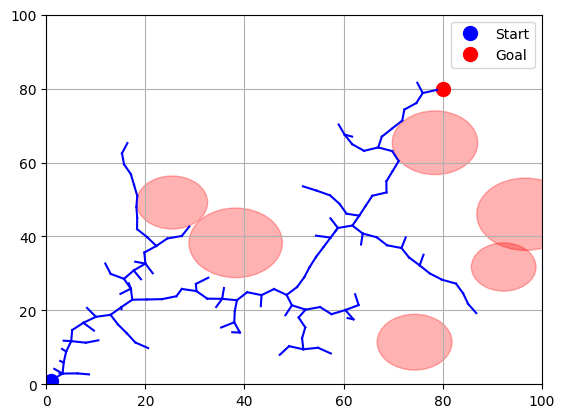

Animation completed and saved as rrt.gif.


In [41]:
start = [1, 1]
goal = [80, 80]
num_obstacles = 6  
map_size = [100, 100]

map = Map(map_size[0], map_size[1], num_obstacles, start, goal)
map.create_obstacle_map

rrt = RRT(map, start, goal)

# Анимация
rrt.build_tree(rrt.step_size / 2)
make_animation(rrt.frames, rrt.fig, 'rrt_smart_step.gif')
print(f"Animation completed and saved as rrt.gif.")

Теперь попробуем запустить наш Vanilla RRT без флага `smart_step` и убедимся, что алгоритм работает дольше и его сильнее "шатает"

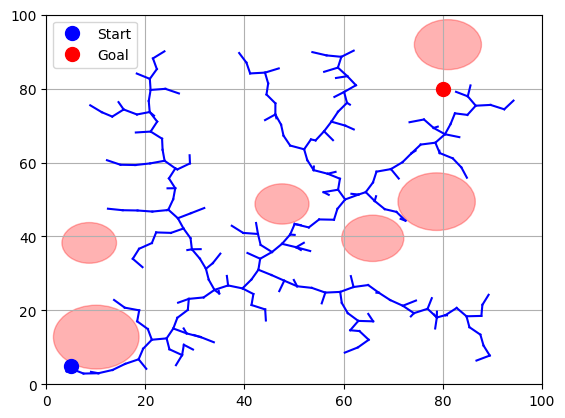

Animation completed and saved as rrt.gif.


In [ ]:
start = [5, 5]
goal = [80, 80]
num_obstacles = 6  
map_size = [100, 100]

map = Map(map_size[0], map_size[1], num_obstacles, start, goal, smart_step=False)
map.create_obstacle_map()

rrt = RRT(map, start, goal)

# Анимация
rrt.build_tree(rrt.step_size) # пришлось увеличить step_size, чтобы алгоритм сходился за приличное время
make_animation(rrt.frames, rrt.fig, 'rrt_no_smart_step.gif')
print(f"Animation completed and saved as rrt.gif.")

### RRT*

In [76]:
class RRTStar:
    def __init__(self, map: Map, start: tuple[float, float], goal: tuple[float, float], neighbor_radius: float = 0.1, max_iter: int = 1000):
        self.map: Map = map
        self.start: Node = Node(start[0], start[1])
        self.goal: Node = Node(goal[0], goal[1])
        self.tree: list[Node] = [self.start]
        self.max_iter: int = max_iter
        self.neighbor_radius: float = min(map.width, map.height) * 0.1
        self.step_size: float = min(map.width, map.height) * 0.03
        self.fig, self.ax = plt.subplots()
        self.frames = []


    def steer(self, node1: Node, node2: Node) -> Node:
        """
        Возвращает точку, находящуюся на расстоянии step_size от node1 и направленную к node2.
        node1 -> step_size -> node2
        """
        dx = node2.x - node1.x
        dy = node2.y - node1.y
        
        distance = math.sqrt(dx**2 + dy**2)
        
        if distance <= self.step_size:
            new_node = Node(node2.x, node2.y)
            new_node.parent = node1
            return new_node
            
        theta = math.atan2(dy, dx)
        new_x = node1.x + self.step_size * math.cos(theta)
        new_y = node1.y + self.step_size * math.sin(theta)
        
        
        new_node = Node(new_x, new_y)
        new_node.parent = node1
        return new_node
   
    def find_nearest_node(self, random_point: tuple[float, float]) -> Node:
        """
        Находит ближайший узел в дереве к случайной точке.
        """
        distances = [np.linalg.norm([node.x - random_point[0], node.y - random_point[1]]) for node in self.tree]
        nearest_node = self.tree[np.argmin(distances)]
        return nearest_node
    
    def get_neighbours(self, new_node: Node) -> list[Node]:
        """
        Находит всех соседей узла.
        """
        return [node for node in self.tree
                if np.linalg.norm([node.x - new_node.x, node.y - new_node.y]) < self.neighbor_radius]
    
    def choose_parent(self, neighbors: list[Node], nearest_node: Node, new_node: Node) -> Node:
        """
        Выбирает родителя для нового узла.
        """
        min_cost = nearest_node.cost + np.linalg.norm([new_node.x - nearest_node.x, new_node.y - nearest_node.y])
        best_node = nearest_node

        for neighbor in neighbors:
            cost = neighbor.cost + np.linalg.norm([new_node.x - neighbor.x, new_node.y - neighbor.y])
            if cost < min_cost:
                best_node = neighbor
                min_cost = cost

        new_node.cost = min_cost
        new_node.parent = best_node
        return new_node
    
    def rewire(self, new_node: Node, neighbours: list[Node]):
        """
        Переподключает соседей нового узла.
        """
        for neighbour in neighbours:
            cost = new_node.cost + np.linalg.norm([neighbour.x - new_node.x, neighbour.y - new_node.y])
            if cost < neighbour.cost:
                neighbour.parent = new_node
                neighbour.cost = cost
    
    def build_tree(self, goal_region_radius):
        """
        Построение дерева RRT.
        """
        all_lines = []

        self.setup_visualization()
        self.frames.append([])

        for _ in range(self.max_iter):
            frame_artists = []
            random_point = self.map.generate_random_point()
            nearest_node = self.find_nearest_node(random_point)
            new_node = self.steer(nearest_node, Node(random_point[0], random_point[1]))
            if self.map.is_collision((new_node.x, new_node.y)):
                continue
            neighbors = self.get_neighbours(new_node)
            if neighbors:
                new_node = self.choose_parent(neighbors, nearest_node, new_node)
                self.rewire(new_node, neighbors)
            self.tree.append(new_node)


            if new_node.parent:
                line, = self.ax.plot([new_node.x, new_node.parent.x], 
                               [new_node.y, new_node.parent.y], "-b")
                all_lines.append(line)
                self.frames.append(all_lines.copy())
            

            # if np.linalg.norm([new_node.x - self.goal.x, new_node.y - self.goal.y]) < goal_region_radius:
            #     break

    def setup_visualization(self):
        """
        Настройка начальной визуализации
        """
        
        self.ax.set_xlim(0, self.map.width)
        self.ax.set_ylim(0, self.map.height)
        
        for (ox, oy, size) in self.map.obstacles:
            circle = plt.Circle((ox, oy), size, color='r', alpha=0.3)
            self.ax.add_artist(circle)
        
        self.ax.plot(self.start.x, self.start.y, 'bo', markersize=10, label='Start')
        self.ax.plot(self.goal.x, self.goal.y, 'ro', markersize=10, label='Goal')
        
        self.ax.grid(True)
        self.ax.legend()


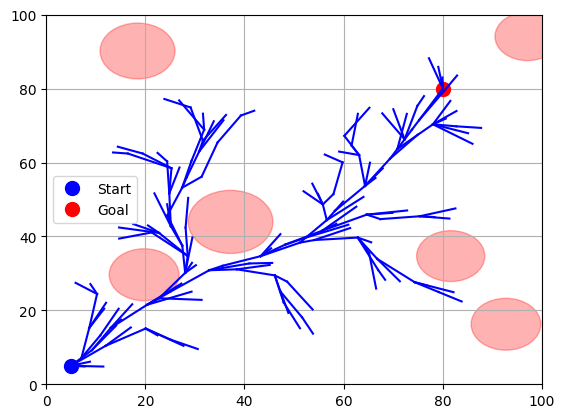

Animation completed and saved as rrt.gif.


In [98]:
start = [5, 5]
goal = [80, 80]
num_obstacles = 6  
map_size = [100, 100]

map = Map(map_size[0], map_size[1], num_obstacles, start, goal)
map.create_obstacle_map()

rrt = RRTStar(map, start, goal, max_iter=200, neighbor_radius=0.2 * min(map.width, map.height)) # ограничиваем количество итераций, чтобы алгоритм сходился за приличное время

# Анимация
rrt.build_tree(rrt.step_size) # пришлось увеличить step_size, чтобы алгоритм сходился за приличное время
make_animation(rrt.frames, rrt.fig, 'rrt_star.gif')
print(f"Animation completed and saved as rrt.gif.")

### RRT-Connect

In [92]:
class RRTConnect:
    def __init__(self, map: Map, start: tuple[float, float], goal: tuple[float, float], max_iter: int = 1000):
        self.map: Map = map
        self.start: Node = Node(start[0], start[1])
        self.goal: Node = Node(goal[0], goal[1])
        self.tree_start: list[Node] = [self.start]  # дерево от старта
        self.tree_goal: list[Node] = [self.goal]    # дерево от цели
        self.max_iter: int = max_iter
        self.step_size: float = min(map.width, map.height) * 0.03
        self.fig, self.ax = plt.subplots()
        self.frames = []


    def steer(self, node1: Node, node2: Node) -> Node:
        """
        Возвращает точку, находящуюся на расстоянии step_size от node1 и направленную к node2.
        node1 -> step_size -> node2
        """
        dx = node2.x - node1.x
        dy = node2.y - node1.y
        
        distance = math.sqrt(dx**2 + dy**2)
        
        if distance <= self.step_size:
            new_node = Node(node2.x, node2.y)
            new_node.parent = node1
            return new_node
            
        theta = math.atan2(dy, dx)
        new_x = node1.x + self.step_size * math.cos(theta)
        new_y = node1.y + self.step_size * math.sin(theta)
        
        new_node = Node(new_x, new_y)
        new_node.parent = node1
        return new_node
   
    def find_nearest_node(self, random_point: tuple[float, float], tree: list[Node]) -> Node:
        """
        Находит ближайший узел в дереве к случайной точке.
        """
        nodes_array = np.array([[node.x, node.y] for node in tree])
        point_array = np.array(random_point)
        distances = np.linalg.norm(nodes_array - point_array, axis=1)
        return tree[np.argmin(distances)]
    
    def extend(self, tree: list[Node], random_point: tuple[float, float]) -> tuple[Node, bool]:
        """
        Расширяет дерево в направлении случайной точки.
        Возвращает новый узел и флаг, указывающий, достиг ли узел случайной точки.
        """
        nearest_node = self.find_nearest_node(random_point, tree)
        new_node = self.steer(nearest_node, Node(random_point[0], random_point[1]))
        
        if self.map.is_collision((new_node.x, new_node.y)):
            return new_node, False
            
        tree.append(new_node)
        return new_node, True
    
    def connect(self, tree: list[Node], target_point: tuple[float, float]) -> tuple[Node, bool]:
        """
        Пытается соединить дерево с целевой точкой.
        """
        reached = False
        while not reached:
            new_node, success = self.extend(tree, target_point)
            if not success:
                return new_node, False
                
            # Проверяем, достигли ли мы целевой точки
            distance = np.linalg.norm([new_node.x - target_point[0], new_node.y - target_point[1]])
            if distance < self.step_size:
                reached = True
                
        return new_node, True
    
    def extract_path(self, goal_node: Node) -> list[tuple[float, float]]:
        """
        Извлекает путь от старта до цели
        """
        path = []
        node = goal_node
        while node is not None:
            path.append((node.x, node.y))
            node = node.parent
        return path[::-1]
        

    def build_tree(self, goal_region_radius):
        """
        Построение дерева RRT-Connect.
        """
        all_lines = []

        self.setup_visualization()
        self.frames.append([])

        for _ in range(self.max_iter):
            frame_artists = []

            random_point = self.map.generate_random_point()
            # Расширяем дерево от старта
            new_node, success = self.extend(self.tree_start, random_point)
            if success:
                # Пытаемся соединить с деревом от цели
                connect_node, connected = self.connect(self.tree_goal, (new_node.x, new_node.y))
                if connected:
                    # Нашли путь
                    self.path = self.extract_path(new_node)
                    break
                    
                # Меняем деревья местами
                self.tree_start, self.tree_goal = self.tree_goal, self.tree_start

            if new_node.parent:
                line, = self.ax.plot([new_node.x, new_node.parent.x], 
                               [new_node.y, new_node.parent.y], "-b")
                all_lines.append(line)
                self.frames.append(all_lines.copy())
            

            # if np.linalg.norm([new_node.x - self.goal.x, new_node.y - self.goal.y]) < goal_region_radius:
            #     break

    def setup_visualization(self):
        """
        Настройка начальной визуализации
        """
        
        self.ax.set_xlim(0, self.map.width)
        self.ax.set_ylim(0, self.map.height)
        
        for (ox, oy, size) in self.map.obstacles:
            circle = plt.Circle((ox, oy), size, color='r', alpha=0.3)
            self.ax.add_artist(circle)
        
        self.ax.plot(self.start.x, self.start.y, 'bo', markersize=10, label='Start')
        self.ax.plot(self.goal.x, self.goal.y, 'ro', markersize=10, label='Goal')
        
        self.ax.grid(True)
        self.ax.legend()

 


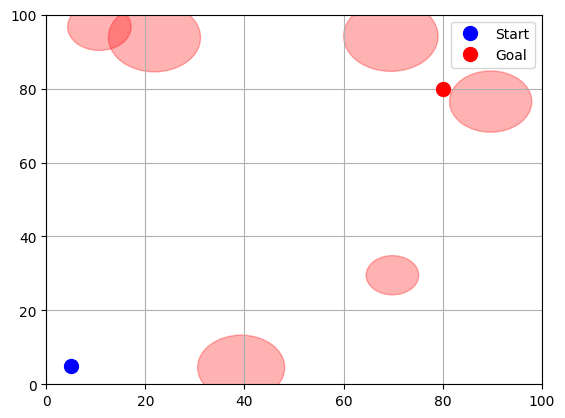

Animation completed and saved as rrt.gif.


In [93]:
start = [5, 5]
goal = [80, 80]
num_obstacles = 6  
map_size = [100, 100]

map = Map(map_size[0], map_size[1], num_obstacles, start, goal)
map.create_obstacle_map()

rrt = RRTConnect(map, start, goal, max_iter=300) # ограничиваем количество итераций, чтобы алгоритм сходился за приличное время

# Анимация
rrt.build_tree(rrt.step_size) # пришлось увеличить step_size, чтобы алгоритм сходился за приличное время
make_animation(rrt.frames, rrt.fig, 'rrt_connect.gif')